## Импорт библиотек, загрузка данных

In [1]:
!pip install category_encoders association-metrics catboost optuna xgboost -q

In [2]:
!pip install lightgbm -q

In [3]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from category_encoders.ordinal import OrdinalEncoder
from category_encoders.one_hot import OneHotEncoder
from category_encoders.target_encoder import TargetEncoder
from category_encoders.leave_one_out import LeaveOneOutEncoder
from sklearn.preprocessing import MinMaxScaler, StandardScaler, PolynomialFeatures
from sklearn.pipeline import Pipeline
import seaborn as sb
import association_metrics as am
from sklearn.model_selection import cross_val_score, train_test_split
from sklearn.metrics import r2_score
from catboost import CatBoostRegressor
import optuna
from sklearn.metrics import mean_absolute_percentage_error as MAPE, mean_absolute_error as MAE, r2_score, mean_squared_error as MSE
from sklearn.linear_model import LinearRegression
from sklearn.ensemble import RandomForestRegressor
from xgboost import XGBRegressor
from sklearn.ensemble import GradientBoostingRegressor

In [4]:
from lightgbm import LGBMRanker, LGBMRegressor

In [5]:
TRAIN = "https://raw.githubusercontent.com/evgpat/edu_stepik_practical_ml/main/datasets/chocolate_train.csv"
TEST = "https://raw.githubusercontent.com/evgpat/edu_stepik_practical_ml/main/datasets/chocolate_test_new.csv"

In [6]:
data = pd.read_csv(TRAIN)

## Обзор данных, подготовка к обучению

In [7]:
data.head()

,Company,Specific Bean Origin,REF,Review,Cocoa Percent,Company Location,Rating,Bean Type,Broad Bean Origin
0,Willie's Cacao,Rio Caribe,457,2009,72%,U.K.,3.25,Trinitario,Venezuela
1,Beschle (Felchlin),"Ocumare, Premier Cru, Quizas No. 2",508,2010,72%,Switzerland,3.50,,Venezuela
2,Dark Forest,Tanzania,1554,2015,70%,U.S.A.,3.00,,Tanzania
3,Brasstown aka It's Chocolate,Cooproagro,1125,2013,72%,U.S.A.,3.00,Trinitario,Dominican Republic
4,Pralus,"Java, Indonesie",32,2006,75%,France,3.50,Criollo,Indonesia


In [8]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1255 entries, 0 to 1254
Data columns (total 9 columns):
 #   Column                Non-Null Count  Dtype  
---  ------                --------------  -----  
 0   Company               1255 non-null   object 
 1   Specific Bean Origin  1255 non-null   object 
 2   REF                   1255 non-null   int64  
 3   Review                1255 non-null   int64  
 4   Cocoa Percent         1255 non-null   object 
 5   Company Location      1255 non-null   object 
 6   Rating                1255 non-null   float64
 7   Bean Type             1254 non-null   object 
 8   Broad Bean Origin     1254 non-null   object 
dtypes: float64(1), int64(2), object(6)
memory usage: 88.4+ KB


In [9]:
data.describe(include='object')

,Company,Specific Bean Origin,Cocoa Percent,Company Location,Bean Type,Broad Bean Origin
count,1255,1255,1255,1255,1254,1254
unique,376,762,40,58,38,84
top,Soma,Madagascar,70%,U.S.A.,,Venezuela
freq,35,39,461,521,628,144


Удаляем все строки с пропусками

In [10]:
data.dropna(axis=0, inplace=True)

<Axes: >

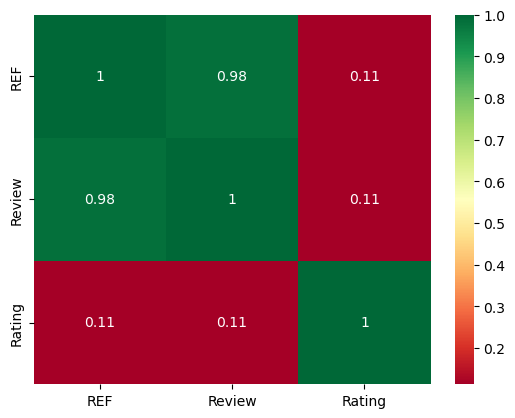

In [11]:
numeric_columns = data.select_dtypes(include=['number']).columns
categorical_columns = data.select_dtypes(exclude=['number']).columns
sb.heatmap(data[numeric_columns].corr(), annot=True, cmap='RdYlGn')

In [12]:
XC = data.apply(lambda x: x.astype("category") if x.dtype == "object" else x)

cramersv = am.CramersV(XC)
cramersv.fit()

c:\Users\Pong\anaconda3\envs\chocolate\lib\site-packages\association_metrics\categorical.py:100: FutureWarning: ChainedAssignmentError: behaviour will change in pandas 3.0!
You are setting values through chained assignment. Currently this works in certain cases, but when using Copy-on-Write (which will become the default behaviour in pandas 3.0) this will never work to update the original DataFrame or Series, because the intermediate object on which we are setting values will behave as a copy.
A typical example is when you are setting values in a column of a DataFrame, like:

df["col"][row_indexer] = value

Use `df.loc[row_indexer, "col"] = values` instead, to perform the assignment in a single step and ensure this keeps updating the original `df`.

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

  self.matrix[x][y] = 1
c:\Users\Pong\anaconda3\envs\chocolate\lib\site-packages\association_metrics

,Company,Specific Bean Origin,Cocoa Percent,Company Location,Bean Type,Broad Bean Origin
Company,1.000000,0.771180,0.631741,0.999651,0.616975,0.607303
Specific Bean Origin,0.771180,1.000000,0.773074,0.808513,0.907951,0.983334
Cocoa Percent,0.631741,0.773074,1.000000,0.243831,0.158698,0.266361
Company Location,0.999651,0.808513,0.243831,1.000000,0.291667,0.383039
Bean Type,0.616975,0.907951,0.158698,0.291667,1.000000,0.388294
Broad Bean Origin,0.607303,0.983334,0.266361,0.383039,0.388294,1.000000


Удаляем столбцы 'Company Location' и 'Review', так как они не информативны

In [13]:
data.drop(['Specific Bean Origin', 'Review'], axis = 1, inplace = True)

In [14]:
numeric_columns = data.select_dtypes(include=['number']).columns
categorical_columns = data.select_dtypes(exclude=['number']).columns

REF


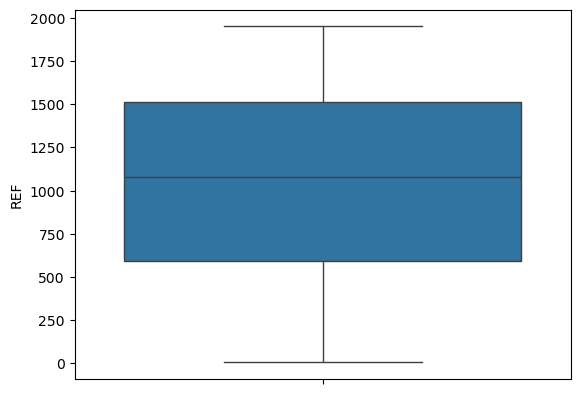

Rating


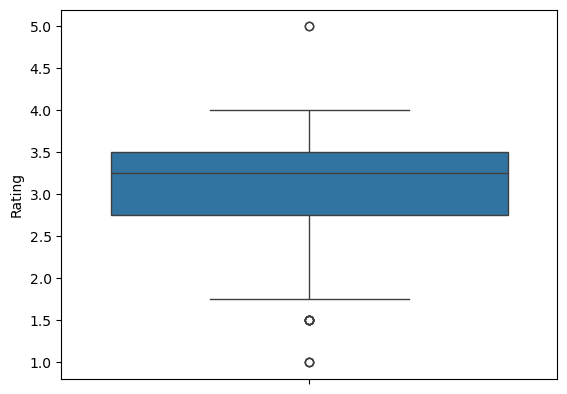

In [15]:
for column in numeric_columns:
    print(column)
    sb.boxplot(data[column])
    plt.show()

Избавляемся от выбросов в целевой переменной

In [16]:
data = data.loc[(data['Rating'] > 1.5) & (data['Rating'] < 5)]

In [17]:
for c in data.columns:
    print(c, len(data[data[c] == '\xa0']))

Company 0
REF 0
Cocoa Percent 0
Company Location 0
Rating 0
Bean Type 621
Broad Bean Origin 49


In [18]:
data['Broad Bean Origin'] = data['Broad Bean Origin'].replace('\xa0', 'Without')

In [19]:
data['Bean Type'] = data['Bean Type'].replace('\xa0', 'Without')
data['Bean Type'].value_counts()

Bean Type
Without                     621
Trinitario                  283
Criollo                     104
Forastero                    52
Forastero (Nacional)         34
Criollo, Trinitario          32
Forastero (Arriba)           30
Blend                        27
Criollo (Porcelana)           9
Forastero (Parazinho)         8
Forastero (Arriba) ASS        6
Trinitario, Criollo           3
Nacional (Arriba)             3
Forastero (Catongo)           2
Criollo, Forastero            2
Criollo (Amarru)              2
Trinitario, Forastero         2
Trinitario (Amelonado)        1
Amazon mix                    1
Trinitario, Nacional          1
Forastero (Amelonado)         1
Criollo (Ocumare 67)          1
Blend-Forastero,Criollo       1
Forastero, Trinitario         1
Criollo (Ocumare 61)          1
Trinitario (85% Criollo)      1
EET                           1
Amazon                        1
Criollo (Wild)                1
Matina                        1
Criollo, +                    

In [20]:
data['Broad Bean Origin'].value_counts()

Broad Bean Origin
Venezuela               143
Ecuador                 139
Peru                    121
Dominican Republic      104
Madagascar              103
                       ... 
Peru, Belize              1
Principe                  1
Venezuela, Ghana          1
Ven.,Ecu.,Peru,Nic.       1
Venezuela, Carribean      1
Name: count, Length: 83, dtype: int64

In [21]:
data['Broad Bean Origin'] = data['Broad Bean Origin'].replace('\xa0', -999)

In [22]:
data['Cocoa Percent'] = data['Cocoa Percent'].apply(lambda x: float(x[0:-1]))

Заменяю столбец 'Cocoa Percent' на категориальный следующим образом
от 90 до 100 - очень темный шоколад
от 70 до 90 - горький
от 53 до 70 -темный
меньше 53 - молочный

In [23]:

data['Cocoa Percent'] = data['Cocoa Percent'].replace(np.arange(90, 100.5, 0.5), 'Ultra Dark')
data['Cocoa Percent'] = data['Cocoa Percent'].replace(np.arange(70, 90, 0.5), 'Bitter')
data['Cocoa Percent'] = data['Cocoa Percent'].replace(np.arange(53, 70, 0.5), 'Dark')
data['Cocoa Percent'] = data['Cocoa Percent'].replace(np.arange(0, 53, 0.5), 'Milk')
data = data.loc[data['Cocoa Percent'] != 'Milk']
# Убираем молочный шоколад, так как его всего 2

In [24]:
data = pd.get_dummies(data, columns = ['Cocoa Percent'])

In [25]:
categorical_columns = data.select_dtypes(exclude=['number']).columns

В столбце заменяю те записи, в которых несколько стран пречислены через запятую и точку с запятой на 'Combined'

In [26]:
data['Broad Bean Origin'] = data['Broad Bean Origin'].apply(lambda x: 'Combined' if len(x.split(", ")) >= 2 or len(x.split("., ")) >= 2 else x)

Выделяем матрицу объект-признак и вектор с целевой переменной

In [27]:
X = data.drop('Rating', axis=1)
y = data['Rating']

## Обучение модели

Устанавливаем катбуст и обучаем его с гиперпараметрами по умолчанию на всех данных

In [28]:
X.info()

<class 'pandas.core.frame.DataFrame'>
Index: 1239 entries, 0 to 1254
Data columns (total 8 columns):
 #   Column                    Non-Null Count  Dtype 
---  ------                    --------------  ----- 
 0   Company                   1239 non-null   object
 1   REF                       1239 non-null   int64 
 2   Company Location          1239 non-null   object
 3   Bean Type                 1239 non-null   object
 4   Broad Bean Origin         1239 non-null   object
 5   Cocoa Percent_Bitter      1239 non-null   bool  
 6   Cocoa Percent_Dark        1239 non-null   bool  
 7   Cocoa Percent_Ultra Dark  1239 non-null   bool  
dtypes: bool(3), int64(1), object(4)
memory usage: 61.7+ KB


In [29]:
cat_features = [0, 3, 4, 5]

In [30]:
Xtrain, Xtest, ytrain, ytest = train_test_split(X, y, test_size=0.25, random_state=42)

In [33]:
# Какао - флоат, удалены пропуски + рейтинг от 1.5 до 5 + без специфик бин ориджин - 0.19590 глубина - 2 кол-во деревьев - 104
# Какао - флоат, удалены пропуски + рейтинг от 1.5 до 5 + без специфик бин ориджин + без Ревью - глубина - 2 кол-во деревьев - 104
def objective(trial):

    max_depth = trial.suggest_int("max_depth", 2, 16)
    n_estimators = trial.suggest_int("n_estimators", 10, 1000)

    estimator = CatBoostRegressor(cat_features = cat_features, max_depth = max_depth, n_estimators=n_estimators, random_state=42, verbose=2)

    estimator.fit(Xtrain, ytrain)
    pred = estimator.predict(Xtest)

    return r2_score(ytest, pred)

study = optuna.create_study(direction="maximize")
study.optimize(objective, n_trials=50)
print(study.best_trial)

[I 2025-05-05 15:26:44,452] A new study created in memory with name: no-name-96f229cd-d597-43d4-aacd-76be3e863c81
[W 2025-05-05 15:26:44,455] Trial 0 failed with parameters: {'max_depth': 12, 'n_estimators': 418} because of the following error: CatBoostError('Bad value for num_feature[non_default_doc_idx=0,feature_idx=2]="U.S.A.": Cannot convert \'b\'U.S.A.\'\' to float').
Traceback (most recent call last):
  File "_catboost.pyx", line 2547, in _catboost.get_float_feature
  File "_catboost.pyx", line 1226, in _catboost._FloatOrNan
  File "_catboost.pyx", line 1021, in _catboost._FloatOrNanFromString
TypeError: Cannot convert 'b'U.S.A.'' to float

During handling of the above exception, another exception occurred:

Traceback (most recent call last):
  File "c:\Users\Pong\anaconda3\envs\chocolate\lib\site-packages\optuna\study\_optimize.py", line 197, in _run_trial
    value_or_values = func(trial)
  File "C:\Users\Pong\AppData\Local\Temp\ipykernel_15216\932434123.py", line 10, in object

CatBoostError: Bad value for num_feature[non_default_doc_idx=0,feature_idx=2]="U.S.A.": Cannot convert 'b'U.S.A.'' to float

In [ ]:
study.best_params

{'max_depth': 2, 'n_estimators': 104}

Делаю обработку и предсказания на тестовых данных

In [ ]:
test_data = pd.read_csv(TEST)

In [ ]:
for c in test_data.columns:
    print(c, len(test_data[test_data[c] == '\xa0']))

Company 0
REF 0
Review 0
Cocoa Percent 0
Company Location 0
Bean Type 259
Broad Bean Origin 18
id 0
Rating 0


In [ ]:
test_data.drop(['Specific Bean Origin', 'Review'], axis = 1, inplace = True)

In [ ]:
test_data['Cocoa Percent'] = test_data['Cocoa Percent'].apply(lambda x: float(x[0:-1]))

In [ ]:
test_data.drop(['Company Location', 'Review', 'REF'], axis = 1, inplace = True)
test_data['Cocoa Percent'] = test_data['Cocoa Percent'].apply(lambda x: float(x[0:-1]))
test_data['Cocoa Percent'] = test_data['Cocoa Percent'].replace(np.arange(90, 100.5, 0.5), 'Ultra Dark')
test_data['Cocoa Percent'] = test_data['Cocoa Percent'].replace(np.arange(70, 90, 0.5), 'Bitter')
test_data['Cocoa Percent'] = test_data['Cocoa Percent'].replace(np.arange(53, 70, 0.5), 'Dark')
test_data['Cocoa Percent'] = test_data['Cocoa Percent'].replace(np.arange(0, 53, 0.5), 'Milk')


In [ ]:
test_data['Broad Bean Origin'] = test_data['Broad Bean Origin'].apply(lambda x: 'Combined' if len(x.split(", ")) >= 2 or len(x.split("., ")) >= 2 else x)

In [ ]:
test_data['Broad Bean Origin'] = test_data['Broad Bean Origin'].replace('\xa0', 'Venezuela')

In [ ]:
test_data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 540 entries, 0 to 539
Data columns (total 7 columns):
 #   Column             Non-Null Count  Dtype  
---  ------             --------------  -----  
 0   Company            540 non-null    object 
 1   REF                540 non-null    int64  
 2   Review             540 non-null    int64  
 3   Cocoa Percent      540 non-null    float64
 4   Company Location   540 non-null    object 
 5   Bean Type          540 non-null    object 
 6   Broad Bean Origin  540 non-null    object 
dtypes: float64(1), int64(2), object(4)
memory usage: 29.7+ KB


In [ ]:
model = CatBoostRegressor(cat_features=cat_features, max_depth=2, n_estimators=104)

In [ ]:
model.fit(X, y)

Learning rate set to 0.266776
0:	learn: 0.4415065	total: 785us	remaining: 80.9ms
1:	learn: 0.4333348	total: 1.88ms	remaining: 95.8ms
2:	learn: 0.4286914	total: 2.71ms	remaining: 91.3ms
3:	learn: 0.4252437	total: 3.51ms	remaining: 87.7ms
4:	learn: 0.4225943	total: 4.31ms	remaining: 85.3ms
5:	learn: 0.4191410	total: 5.11ms	remaining: 83.5ms
6:	learn: 0.4182469	total: 5.89ms	remaining: 81.6ms
7:	learn: 0.4163316	total: 6.67ms	remaining: 80.1ms
8:	learn: 0.4136144	total: 7.46ms	remaining: 78.7ms
9:	learn: 0.4127490	total: 8.24ms	remaining: 77.4ms
10:	learn: 0.4120070	total: 9.01ms	remaining: 76.2ms
11:	learn: 0.4107505	total: 9.88ms	remaining: 75.7ms
12:	learn: 0.4105891	total: 10.6ms	remaining: 74.3ms
13:	learn: 0.4095513	total: 11.4ms	remaining: 73.5ms
14:	learn: 0.4077222	total: 12.2ms	remaining: 72.5ms
15:	learn: 0.4065758	total: 13ms	remaining: 71.6ms
16:	learn: 0.4058703	total: 13.8ms	remaining: 70.5ms
17:	learn: 0.4045839	total: 14.5ms	remaining: 69.5ms
18:	learn: 0.4041512	total: 1

Делаем предсказание

In [ ]:
pred = model.predict(test_data)

In [ ]:
for i,j in zip(model.feature_names_, model.feature_importances_):
  print(i, j)

Company 38.585501310548906
REF 14.971301882778887
Review 1.9738462567034936
Cocoa Percent 24.959366645755523
Company Location 7.328523846809313
Bean Type 6.6814977656849095
Broad Bean Origin 5.499962291718944


Сохраняем предсказание в файл в нужном формате

In [ ]:
test_data['id'] = np.arange(len(test_data))
test_data['Rating'] = pred

test_data[['id','Rating']].to_csv("baseline_submission_9.csv", index=False)